<a href="https://colab.research.google.com/github/lipiecki/energy-analytics-2025/blob/main/notebooks/PostForecasts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PostForecasts - postprocessing point forecasts with Julia

Install the **PostForecasts** package in the runtime environment

In [1]:
using Pkg
Pkg.add("PostForecasts")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed BenchmarkTools ────────── v1.6.0
   Installed MutableArithmetics ────── v1.6.4
   Installed CodecBzip2 ────────────── v0.8.5
   Installed HiGHS_jll ─────────────── v1.9.0+0
   Installed Hwloc_jll ─────────────── v2.12.0+0
   Installed Git_jll ───────────────── v2.47.1+0
   Installed RegistryInstances ─────── v0.1.0
   Installed StructTypes ───────────── v1.11.0
   Installed CommonSubexpressions ──── v0.3.1
   Installed MathOptInterface ──────── v1.37.2
   Installed MicrosoftMPI_jll ──────── v10.1.4+3
   Installed MPIPreferences ────────── v0.1.11
   Installed PostForecasts ─────────── v0.1.0
   Installed JSON3 ─────────────────── v1.14.1
   Installed HDF5_jll ──────────────── v1.14.6+0
   Installed MPICH_jll ─────────────── v4.3.0+1
   Installed ANSIColoredPrinters ───── v0.0.1
   Installed DiffRules ─────────────── v1.15.1
   Installed DiffResults ───────────── v1.1.0
   Installed

In [10]:
using PostForecasts, Plots

### Select postprocessing methods and create a dictionary for storing the results

In [3]:
methods = [:idr, :cp, :qr, :normal]
qf = Dict((m => [] for m in methods)...);

### Postprocess LEAR forecasts from the EPEX dataset [(see details)](https://lipiecki.github.io/PostForecasts.jl/stable/datasets/#EPEX)

In [4]:
for h in 1:24
    pf = loaddata("epex$(h)")
    for m in methods
        postprocessed = point2quant(pf, method=m, window=56, quantiles=9, start=20230101, stop=20231231)
        push!(qf[m], postprocessed)
    end
end

### Average the predictive distributions from different methods

In [5]:
qf[:ave] = []
for h in 1:24
    averaged = paverage([qf[m][h] for m in [:idr, :cp, :qr]])
    push!(qf[:ave], averaged)
end

### Calculate the CRPS

In [6]:
score = [sum(crps.(qf[m]))/24 for m in [:idr, :cp, :qr, :ave]]

4-element Vector{Float64}:
 9.751618049213597
 9.822377344968775
 9.985838952660474
 9.248376198364232

### Calculate skill scores - relative improvement over the benchmark model (normally distributed errors)

In [7]:
benchmark_score = sum(crps.(qf[:normal]))/24
skill_score = 100*(1 .- (score ./ benchmark_score))

4-element Vector{Float64}:
  2.295048957833934
  1.5860862510659657
 -0.051694094328014195
  7.337209156424917

### Plot the skill scores

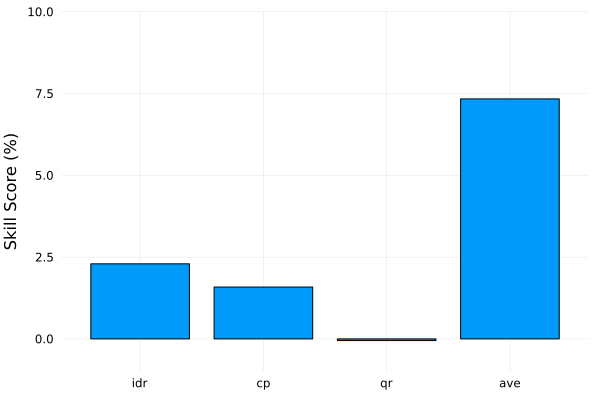

In [11]:
plot(bar(1:4, skill_score, label = "", bar_width = 0.8,
	xticks=(1:4, [:idr, :cp, :qr, :ave])))
plot!(framestyle=:grid, ylims = (-1, 10), ylabel = "Skill Score (%)")